In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-31 18:03:10.848840: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-31 18:03:24.533965: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-31 18:03:24.543887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-31 18:03:24.543921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-31 18:03:24.546647: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-31 18:03:24.549281: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 513)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [6]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

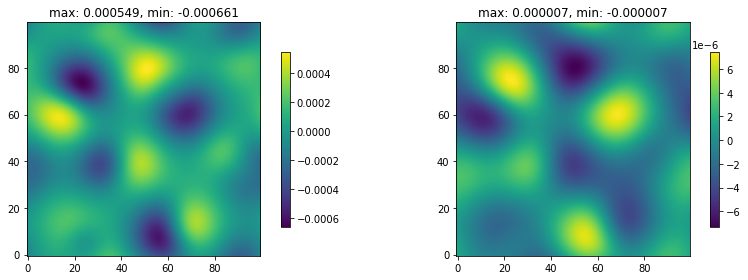

In [7]:
index = -1
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"max: {np.max(c_t[0,:,:, index]):.6f}, min: {np.min(c_t[0,:,:, index]):.6f}")
plt.imshow(c_t[0,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title(f"max: {np.max(c_t[1,:,:, index]):.6f}, min: {np.min(c_t[1,:,:, index]):.6f}")
plt.imshow(c_t[1,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.tight_layout()
plt.show()

In [8]:
data.shape

(2, 100, 100, 513)

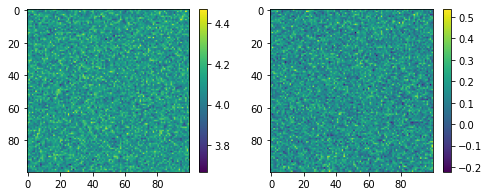

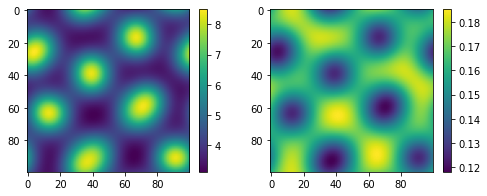

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [10]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
#outputs_correction_fact = [1, 1, .25, .25, 1000, 2.5, 2.5, 10000]
#xx_factors = [.25, 2.5]
#yy_factors = [.25, 2.5]
#t_factors = [1000, 10000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
#c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
#c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
#c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
#diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [12]:
c_xx.shape

(2, 100, 100, 513)

In [13]:
T

513

In [14]:
c_t.shape

(2, 100, 100, 512)

In [15]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [16]:
T

2

In [17]:
data.shape

(2, 100, 100, 2)

In [18]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
# der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [19]:
dataset['output_ub']- dataset['output_lb']

array([5.40405376, 0.06779475])

In [20]:
#ref_scale = (dataset['output_ub']- dataset['output_lb'])[0]
#output_scales = np.array([ref_scale/s for s in dataset['output_ub']- dataset['output_lb']])
#der_u_scales = np.array([ref_scale/s for s in dataset['derivatives_u_ub'] - dataset['derivatives_u_lb']])
#der_v_scales = np.array([ref_scale/s for s in dataset['derivatives_v_ub'] - dataset['derivatives_v_lb']])
#scales = np.concatenate([output_scales, der_u_scales, der_v_scales])
output_scales = np.array([1.0, 1.0])
der_u_scales = np.array([1.0, 1.0, 1])
der_v_scales = np.array([1.0, 1.0, 1])
scales = np.concatenate([output_scales, der_u_scales, der_v_scales])
print(scales)
#scales = np.array([1, 1, .25, .25, 1000, 2.5, 2.5, 10000])
#scales

[1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
1/scales

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
relative_mean_denominators = np.concatenate([np.mean((obs_outputs*output_scales)**2, axis=0),
                                             np.mean((der_u_outputs*der_u_scales)**2, axis=0),
                                             np.mean((der_v_outputs*der_v_scales)**2, axis=0), 
                                             [1.0, 1.0]])

In [23]:
relative_mean_denominators

array([2.66676209e+01, 2.48767911e-02, 5.58123082e+00, 4.40166448e+00,
       5.87262556e-08, 7.02052653e-04, 4.77832010e-04, 1.05590128e-11,
       1.00000000e+00, 1.00000000e+00])

In [24]:
obs_X.shape

(32, 11)

In [25]:
c_xx.shape

(2, 100, 100, 2)

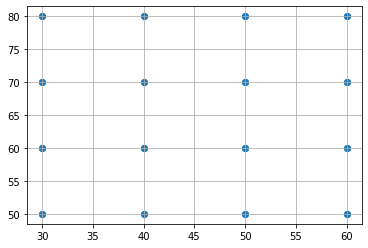

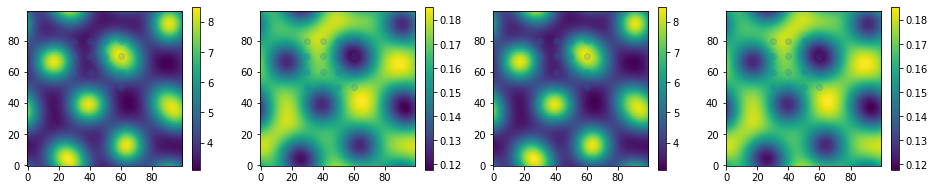

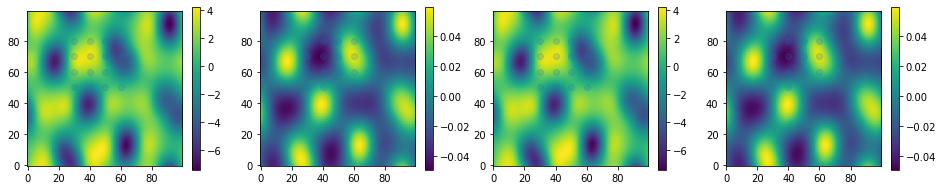

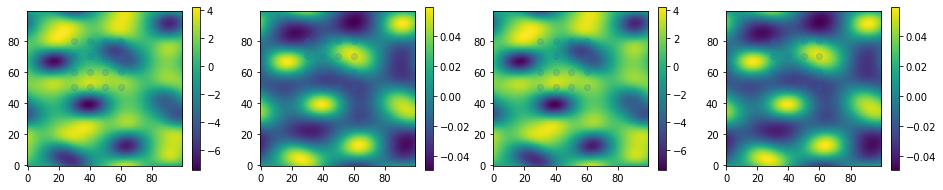

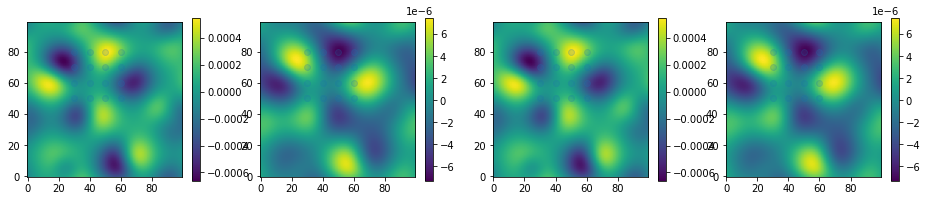

In [26]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is changing in the outer arrays. So, we must transpose them on
##                ploting time
def plot_domain(d, scale_1=1.0, scale_2=1.0):
    _ = plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(142)
    plt.imshow(d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(143)
    plt.imshow(scale_1*d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.subplot(144)
    plt.imshow(scale_2*d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
    plt.show()

plot_domain(data, scale_1=scales[0], scale_2=scales[1])
plot_domain(c_xx, scale_1=scales[2], scale_2=scales[5])
plot_domain(c_yy, scale_1=scales[3], scale_2=scales[6])
plot_domain(c_t, scale_1=scales[4], scale_2=scales[7])



In [27]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [28]:
ds_obs.sizes

array([32, 32])

In [29]:
1024*8

8192

In [87]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 32, 32, 32, 32, 8]
#layers = [3, 2048, 2048, 8]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard_output_as_Der(
                    dtype = pinnKM.dtype,
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 0.0,dtype=pinnKM.dtype, zero_lb=True),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

                    #                    dtype=pinnKM.dtype),
    outputs_scales = 1.0/scales,#[1, 1, 4, 4, 1/1000, 0.4, 0.4, 1/10000],
    loss_grad_type=Loss_Grad_Type.PARAMETER,
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
#obs_loss = Observation_Loss(layers=layers, 
#                           residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))

obs_loss = Scaled_Output_Loss(dtype = pinnKM.dtype,
                              layers=layers, 
                              scales=scales,
                              loss_grad_type=Loss_Grad_Type.PINN,
                              residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
#der_loss = All_Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
#                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN_Inverse(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [88]:
relative_mean_denominators

array([2.66676209e+01, 2.48767911e-02, 5.58123082e+00, 4.40166448e+00,
       5.87262556e-08, 7.02052653e-04, 4.77832010e-04, 1.05590128e-11,
       1.00000000e+00, 1.00000000e+00])

In [89]:
results_KM = modelKM.train(epochs = 2+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )


Start of epoch 0
total loss: 144.971324995160, total regularised loss: 144.971313476562
Observation_Loss -> 
(1)  u: 26.129093170166 (2)  v: 0.026291252521 (3)  u_xx: 5.567817926407 
(4)  u_yy: 4.359014689922 (5)  u_t: 0.024884693790 (6)  v_xx: 0.020669602207 
(7)  v_yy: 0.043692502193 (8)  v_t: 0.015010059811 
Loss_Koch_Meinhard -> 
(9)  res u: 0.022578492993 (10)  res v: 0.033778908662 
sigma_u: 0.00059 sigma_v: 0.00007 mu_u: 0.00000 rho_u: 0.00000 
rho_v: 0.00000 kappa_u: 0.00000 
Time taken: 2.35s

Start of epoch 1
total loss: 142.370207032189, total regularised loss: 142.370208740234
Observation_Loss -> 
(1)  u: 25.560629367828 (2)  v: 0.024612897076 (3)  u_xx: 5.530041694641 
(4)  u_yy: 4.338542401791 (5)  u_t: 0.021265071467 (6)  v_xx: 0.018182783155 
(7)  v_yy: 0.038809758611 (8)  v_t: 0.012554347748 
Loss_Koch_Meinhard -> 
(9)  res u: 0.018911763560 (10)  res v: 0.029002791271 
sigma_u: 0.00025 sigma_v: 0.00010 mu_u: 0.00000 rho_u: 0.00000 
rho_v: 0.00000 kappa_u: 0.00000 
Ti

In [134]:
results_KM = modelKM.train(epochs = 20000+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )

# modelKM.optimizer.lr.assign(1e-4)
# results_KM2 = modelKM.train(epochs = 100000+1,
#                           batch_size = 245,
#                           dataset = ds_obs,
#                           print_interval=1000,
#                           stop_threshold = 1e-9,
#                           sample_losses = True,              
#                           sample_regularisations = False,
#                           regularise=False,
#                           regularise_interval=1,
#                            relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 145.599338315427, total regularised loss: 145.599334716797
Observation_Loss -> 
(1)  u: 25.982357978821 (2)  v: 0.080971114687 (3)  u_xx: 5.727597475052 
(4)  u_yy: 4.399183392525 (5)  u_t: 0.006274314386 (6)  v_xx: 0.009432200051 
(7)  v_yy: 0.057659700979 (8)  v_t: 0.087559130043 
Loss_Koch_Meinhard -> 
(9)  res u: 0.010387519171 (10)  res v: 0.038411941146 
sigma_u: 0.00106 sigma_v: 0.00051 mu_u: 0.00000 rho_u: 0.00000 
rho_v: 0.00124 kappa_u: 0.00000 
Time taken: 2.48s

Start of epoch 1000
total loss: 0.292639748659, total regularised loss: 0.292639732361
Observation_Loss -> 
(1)  u: 0.001483084139 (2)  v: 0.000153252793 (3)  u_xx: 0.002070428833 
(4)  u_yy: 0.000640518920 (5)  u_t: 0.000025765169 (6)  v_xx: 0.000087036969 
(7)  v_yy: 0.000184608186 (8)  v_t: 0.000415948414 
Loss_Koch_Meinhard -> 
(9)  res u: 0.067481951788 (10)  res v: 0.000617342543 
sigma_u: 0.00000 sigma_v: 0.09113 mu_u: 0.11401 rho_u: 0.15491 
rho_v: 0.02269 kappa_u: 0.00000 
Time


Start of epoch 17000
total loss: 0.002919940955, total regularised loss: 0.002919940976
Observation_Loss -> 
(1)  u: 0.000009649869 (2)  v: 0.000000303301 (3)  u_xx: 0.000020672372 
(4)  u_yy: 0.000009203713 (5)  u_t: 0.000000259326 (6)  v_xx: 0.000001318295 
(7)  v_yy: 0.000000476791 (8)  v_t: 0.000000383264 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000684594539 (10)  res v: 0.000003123791 
sigma_u: 0.43133 sigma_v: 0.10018 mu_u: 0.70098 rho_u: 0.76663 
rho_v: 0.02503 kappa_u: 0.00000 
Time taken: 40.97s

Start of epoch 18000
total loss: 0.002837198517, total regularised loss: 0.002837198321
Observation_Loss -> 
(1)  u: 0.000007902367 (2)  v: 0.000001559834 (3)  u_xx: 0.000013748497 
(4)  u_yy: 0.000009521025 (5)  u_t: 0.000000542905 (6)  v_xx: 0.000000255232 
(7)  v_yy: 0.000000765211 (8)  v_t: 0.000000833774 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000673043767 (10)  res v: 0.000001127023 
sigma_u: 0.45068 sigma_v: 0.10001 mu_u: 0.71094 rho_u: 0.77416 
rho_v: 0.02500 kappa_u: 0.00000 
Tim

In [135]:
results_KM2 = modelKM.train(epochs = 20000+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )


Start of epoch 0
total loss: 0.003780767639, total regularised loss: 0.003780767787
Observation_Loss -> 
(1)  u: 0.000003658528 (2)  v: 0.000002313827 (3)  u_xx: 0.000004573969 
(4)  u_yy: 0.000004375197 (5)  u_t: 0.000000316813 (6)  v_xx: 0.000000252203 
(7)  v_yy: 0.000000305208 (8)  v_t: 0.000000251219 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000927419227 (10)  res v: 0.000001725731 
sigma_u: 0.48423 sigma_v: 0.10001 mu_u: 0.72863 rho_u: 0.78816 
rho_v: 0.02500 kappa_u: 0.00000 
Time taken: 0.10s

Start of epoch 1000
total loss: 0.001715557159, total regularised loss: 0.001715557184
Observation_Loss -> 
(1)  u: 0.000002840171 (2)  v: 0.000000118001 (3)  u_xx: 0.000004119680 
(4)  u_yy: 0.000004116486 (5)  u_t: 0.000000048708 (6)  v_xx: 0.000000351080 
(7)  v_yy: 0.000000136749 (8)  v_t: 0.000000094850 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000416138286 (10)  res v: 0.000000925275 
sigma_u: 0.49895 sigma_v: 0.10008 mu_u: 0.73683 rho_u: 0.79464 
rho_v: 0.02498 kappa_u: 0.00000 
Time take


Start of epoch 17000
total loss: 0.000580369858, total regularised loss: 0.000580369844
Observation_Loss -> 
(1)  u: 0.000000629280 (2)  v: 0.000000040490 (3)  u_xx: 0.000001240877 
(4)  u_yy: 0.000000640813 (5)  u_t: 0.000000145147 (6)  v_xx: 0.000000134037 
(7)  v_yy: 0.000000453210 (8)  v_t: 0.000000629636 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000141023860 (10)  res v: 0.000000155114 
sigma_u: 0.68415 sigma_v: 0.10002 mu_u: 0.83424 rho_u: 0.87067 
rho_v: 0.02500 kappa_u: 0.00000 
Time taken: 41.02s

Start of epoch 18000
total loss: 0.002040370136, total regularised loss: 0.002040370135
Observation_Loss -> 
(1)  u: 0.000006355586 (2)  v: 0.000000437929 (3)  u_xx: 0.000007711487 
(4)  u_yy: 0.000003165811 (5)  u_t: 0.000000416911 (6)  v_xx: 0.000000958256 
(7)  v_yy: 0.000000281803 (8)  v_t: 0.000000869498 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000488383861 (10)  res v: 0.000001511384 
sigma_u: 0.69329 sigma_v: 0.10004 mu_u: 0.83879 rho_u: 0.87453 
rho_v: 0.02503 kappa_u: 0.00000 
Tim

In [136]:
results_KM3 = modelKM.train(epochs = 60000+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )


Start of epoch 0
total loss: 0.001435879418, total regularised loss: 0.001435879385
Observation_Loss -> 
(1)  u: 0.000014230540 (2)  v: 0.000000262389 (3)  u_xx: 0.000015988754 
(4)  u_yy: 0.000012973069 (5)  u_t: 0.000000418539 (6)  v_xx: 0.000000554318 
(7)  v_yy: 0.000000300542 (8)  v_t: 0.000000596520 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000311358506 (10)  res v: 0.000002286686 
sigma_u: 0.71003 sigma_v: 0.10006 mu_u: 0.84818 rho_u: 0.88214 
rho_v: 0.02501 kappa_u: 0.00002 
Time taken: 0.07s

Start of epoch 1000
total loss: 0.000835288878, total regularised loss: 0.000835288898
Observation_Loss -> 
(1)  u: 0.000010973785 (2)  v: 0.000000134020 (3)  u_xx: 0.000007203127 
(4)  u_yy: 0.000013713261 (5)  u_t: 0.000000129175 (6)  v_xx: 0.000001014323 
(7)  v_yy: 0.000000438087 (8)  v_t: 0.000000455487 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000172102827 (10)  res v: 0.000002658134 
sigma_u: 0.71844 sigma_v: 0.10006 mu_u: 0.85272 rho_u: 0.88546 
rho_v: 0.02505 kappa_u: 0.00000 
Time take


Start of epoch 17000
total loss: 0.000868927351, total regularised loss: 0.000868927338
Observation_Loss -> 
(1)  u: 0.000003058446 (2)  v: 0.000000087397 (3)  u_xx: 0.000001505982 
(4)  u_yy: 0.000004940929 (5)  u_t: 0.000000424147 (6)  v_xx: 0.000000085491 
(7)  v_yy: 0.000000458342 (8)  v_t: 0.000000203777 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000205340341 (10)  res v: 0.000001126990 
sigma_u: 0.81905 sigma_v: 0.10004 mu_u: 0.90598 rho_u: 0.92737 
rho_v: 0.02504 kappa_u: 0.00000 
Time taken: 39.66s

Start of epoch 18000
total loss: 0.002009499593, total regularised loss: 0.002009499585
Observation_Loss -> 
(1)  u: 0.000004612214 (2)  v: 0.000000604162 (3)  u_xx: 0.000006760645 
(4)  u_yy: 0.000018579961 (5)  u_t: 0.000001748211 (6)  v_xx: 0.000004123241 
(7)  v_yy: 0.000000741072 (8)  v_t: 0.000000790495 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000457076974 (10)  res v: 0.000007337927 
sigma_u: 0.82287 sigma_v: 0.10005 mu_u: 0.90783 rho_u: 0.92936 
rho_v: 0.02513 kappa_u: 0.00000 
Tim


Start of epoch 34000
total loss: 0.004572514704, total regularised loss: 0.004572514445
Observation_Loss -> 
(1)  u: 0.000008240427 (2)  v: 0.000002420257 (3)  u_xx: 0.000010354756 
(4)  u_yy: 0.000004662710 (5)  u_t: 0.000001003020 (6)  v_xx: 0.000000761992 
(7)  v_yy: 0.000001486319 (8)  v_t: 0.000000672235 
Loss_Koch_Meinhard -> 
(9)  res u: 0.001111350895 (10)  res v: 0.000002176071 
sigma_u: 0.86453 sigma_v: 0.10012 mu_u: 0.92951 rho_u: 0.94601 
rho_v: 0.02499 kappa_u: 0.00000 
Time taken: 39.95s

Start of epoch 35000
total loss: 0.001691397585, total regularised loss: 0.001691397512
Observation_Loss -> 
(1)  u: 0.000004664492 (2)  v: 0.000000646952 (3)  u_xx: 0.000006218596 
(4)  u_yy: 0.000000882879 (5)  u_t: 0.000001994697 (6)  v_xx: 0.000003299553 
(7)  v_yy: 0.000000176712 (8)  v_t: 0.000002584390 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000384246850 (10)  res v: 0.000018134286 
sigma_u: 0.86573 sigma_v: 0.09996 mu_u: 0.93065 rho_u: 0.94700 
rho_v: 0.02515 kappa_u: 0.00000 
Tim


Start of epoch 51000
total loss: 0.000477742725, total regularised loss: 0.000477742724
Observation_Loss -> 
(1)  u: 0.000000029503 (2)  v: 0.000000032916 (3)  u_xx: 0.000000032994 
(4)  u_yy: 0.000000051577 (5)  u_t: 0.000000055921 (6)  v_xx: 0.000000079935 
(7)  v_yy: 0.000000014309 (8)  v_t: 0.000000040886 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000118848104 (10)  res v: 0.000000249540 
sigma_u: 0.89272 sigma_v: 0.10010 mu_u: 0.94507 rho_u: 0.95825 
rho_v: 0.02502 kappa_u: 0.00000 
Time taken: 40.59s

Start of epoch 52000
total loss: 0.000838703010, total regularised loss: 0.000838703010
Observation_Loss -> 
(1)  u: 0.000003338988 (2)  v: 0.000000296164 (3)  u_xx: 0.000002226558 
(4)  u_yy: 0.000001679325 (5)  u_t: 0.000000100076 (6)  v_xx: 0.000000133620 
(7)  v_yy: 0.000000215752 (8)  v_t: 0.000001132595 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000199750434 (10)  res v: 0.000000802245 
sigma_u: 0.89470 sigma_v: 0.10012 mu_u: 0.94579 rho_u: 0.95869 
rho_v: 0.02497 kappa_u: 0.00004 
Tim

In [143]:
results_KM4 = modelKM.train(epochs = 50000+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )


Start of epoch 0
total loss: 0.000517950097, total regularised loss: 0.000517950044
Observation_Loss -> 
(1)  u: 0.000000005250 (2)  v: 0.000000085910 (3)  u_xx: 0.000000007593 
(4)  u_yy: 0.000000027688 (5)  u_t: 0.000000062732 (6)  v_xx: 0.000000005812 
(7)  v_yy: 0.000000004067 (8)  v_t: 0.000000006334 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000129195673 (10)  res v: 0.000000086470 
sigma_u: 0.90202 sigma_v: 0.10010 mu_u: 0.95001 rho_u: 0.96234 
rho_v: 0.02505 kappa_u: 0.00000 
Time taken: 0.11s

Start of epoch 1000
total loss: 0.002245399624, total regularised loss: 0.002245399635
Observation_Loss -> 
(1)  u: 0.000002746787 (2)  v: 0.000000625827 (3)  u_xx: 0.000007155646 
(4)  u_yy: 0.000002431421 (5)  u_t: 0.000000057023 (6)  v_xx: 0.000000823828 
(7)  v_yy: 0.000000483112 (8)  v_t: 0.000000645980 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000545478430 (10)  res v: 0.000000901848 
sigma_u: 0.90337 sigma_v: 0.10010 mu_u: 0.95045 rho_u: 0.96241 
rho_v: 0.02505 kappa_u: 0.00000 
Time take


Start of epoch 17000
total loss: 0.001424599770, total regularised loss: 0.001424599788
Observation_Loss -> 
(1)  u: 0.000017600538 (2)  v: 0.000000648486 (3)  u_xx: 0.000015444100 
(4)  u_yy: 0.000013153894 (5)  u_t: 0.000000211913 (6)  v_xx: 0.000002501145 
(7)  v_yy: 0.000001802977 (8)  v_t: 0.000001275050 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000299145839 (10)  res v: 0.000004365994 
sigma_u: 0.91160 sigma_v: 0.10009 mu_u: 0.95545 rho_u: 0.96636 
rho_v: 0.02513 kappa_u: 0.00000 
Time taken: 40.44s

Start of epoch 18000
total loss: 0.000493224017, total regularised loss: 0.000493224012
Observation_Loss -> 
(1)  u: 0.000002272967 (2)  v: 0.000000208105 (3)  u_xx: 0.000001498050 
(4)  u_yy: 0.000005207537 (5)  u_t: 0.000000243604 (6)  v_xx: 0.000000964964 
(7)  v_yy: 0.000000179441 (8)  v_t: 0.000000543760 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000110810224 (10)  res v: 0.000001377351 
sigma_u: 0.91268 sigma_v: 0.10010 mu_u: 0.95573 rho_u: 0.96654 
rho_v: 0.02500 kappa_u: 0.00002 
Tim


Start of epoch 34000
total loss: 0.000253311439, total regularised loss: 0.000253311446
Observation_Loss -> 
(1)  u: 0.000001272416 (2)  v: 0.000000060882 (3)  u_xx: 0.000000331485 
(4)  u_yy: 0.000000986381 (5)  u_t: 0.000000009732 (6)  v_xx: 0.000000056661 
(7)  v_yy: 0.000000067941 (8)  v_t: 0.000000037933 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000060363835 (10)  res v: 0.000000140594 
sigma_u: 0.91882 sigma_v: 0.10008 mu_u: 0.95894 rho_u: 0.96912 
rho_v: 0.02506 kappa_u: 0.00000 
Time taken: 40.49s

Start of epoch 35000
total loss: 0.000195055232, total regularised loss: 0.000195055240
Observation_Loss -> 
(1)  u: 0.000000042693 (2)  v: 0.000000040540 (3)  u_xx: 0.000000053794 
(4)  u_yy: 0.000000144800 (5)  u_t: 0.000000007306 (6)  v_xx: 0.000000043333 
(7)  v_yy: 0.000000023384 (8)  v_t: 0.000000327533 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000047455732 (10)  res v: 0.000000624690 
sigma_u: 0.91805 sigma_v: 0.10009 mu_u: 0.95892 rho_u: 0.96932 
rho_v: 0.02502 kappa_u: 0.00001 
Tim

In [146]:
modelKM.optimizer.lr.assign(2e-4)
results_KM5 = modelKM.train(epochs = 50000+1,
                          batch_size = 8,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-9,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=None#relative_mean_denominators
                          )


Start of epoch 0
total loss: 0.000086364608, total regularised loss: 0.000086364613
Observation_Loss -> 
(1)  u: 0.000000007817 (2)  v: 0.000000010840 (3)  u_xx: 0.000000006944 
(4)  u_yy: 0.000000012855 (5)  u_t: 0.000000023414 (6)  v_xx: 0.000000077151 
(7)  v_yy: 0.000000005206 (8)  v_t: 0.000000198737 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000021219008 (10)  res v: 0.000000029180 
sigma_u: 0.92117 sigma_v: 0.10005 mu_u: 0.95990 rho_u: 0.96965 
rho_v: 0.02502 kappa_u: 0.00001 
Time taken: 0.10s

Start of epoch 1000
total loss: 0.000371132420, total regularised loss: 0.000371132395
Observation_Loss -> 
(1)  u: 0.000000094599 (2)  v: 0.000000098646 (3)  u_xx: 0.000000139197 
(4)  u_yy: 0.000000148145 (5)  u_t: 0.000000059475 (6)  v_xx: 0.000000099465 
(7)  v_yy: 0.000000045124 (8)  v_t: 0.000000119740 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000091328516 (10)  res v: 0.000000650199 
sigma_u: 0.92565 sigma_v: 0.10009 mu_u: 0.96144 rho_u: 0.97042 
rho_v: 0.02499 kappa_u: 0.00002 
Time take


Start of epoch 17000
total loss: 0.000185517676, total regularised loss: 0.000185517682
Observation_Loss -> 
(1)  u: 0.000000155793 (2)  v: 0.000000036977 (3)  u_xx: 0.000000088355 
(4)  u_yy: 0.000000108965 (5)  u_t: 0.000000002254 (6)  v_xx: 0.000000472262 
(7)  v_yy: 0.000000032894 (8)  v_t: 0.000000079135 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000044845118 (10)  res v: 0.000000557666 
sigma_u: 0.96200 sigma_v: 0.10001 mu_u: 0.98087 rho_u: 0.98574 
rho_v: 0.02504 kappa_u: 0.00000 
Time taken: 40.61s

Start of epoch 18000
total loss: 0.000128847375, total regularised loss: 0.000128847372
Observation_Loss -> 
(1)  u: 0.000000012394 (2)  v: 0.000000034092 (3)  u_xx: 0.000000029016 
(4)  u_yy: 0.000000009994 (5)  u_t: 0.000000063619 (6)  v_xx: 0.000000006250 
(7)  v_yy: 0.000000020647 (8)  v_t: 0.000000009035 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000031967138 (10)  res v: 0.000000059657 
sigma_u: 0.96335 sigma_v: 0.10005 mu_u: 0.98162 rho_u: 0.98624 
rho_v: 0.02501 kappa_u: 0.00000 
Tim


Start of epoch 34000
total loss: 0.000241644227, total regularised loss: 0.000241644229
Observation_Loss -> 
(1)  u: 0.000000039631 (2)  v: 0.000000026350 (3)  u_xx: 0.000000037556 
(4)  u_yy: 0.000000108756 (5)  u_t: 0.000000004416 (6)  v_xx: 0.000000073046 
(7)  v_yy: 0.000000014782 (8)  v_t: 0.000000067765 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000059880270 (10)  res v: 0.000000158487 
sigma_u: 0.97758 sigma_v: 0.10004 mu_u: 0.98903 rho_u: 0.99215 
rho_v: 0.02502 kappa_u: 0.00000 
Time taken: 39.93s

Start of epoch 35000
total loss: 0.000055981135, total regularised loss: 0.000055981138
Observation_Loss -> 
(1)  u: 0.000000044588 (2)  v: 0.000000016936 (3)  u_xx: 0.000000023909 
(4)  u_yy: 0.000000025191 (5)  u_t: 0.000000090348 (6)  v_xx: 0.000000025385 
(7)  v_yy: 0.000000134236 (8)  v_t: 0.000000025770 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000013563923 (10)  res v: 0.000000044997 
sigma_u: 0.97787 sigma_v: 0.10004 mu_u: 0.98937 rho_u: 0.99243 
rho_v: 0.02502 kappa_u: 0.00001 
Tim

In [ ]:
'sigma_u': 1.0, 'sigma_v': 0.1 , 'mu_u': 1.0, 'rho_u': 1.0, 
'rho_v': 0.025, 'kappa_u': 0.0

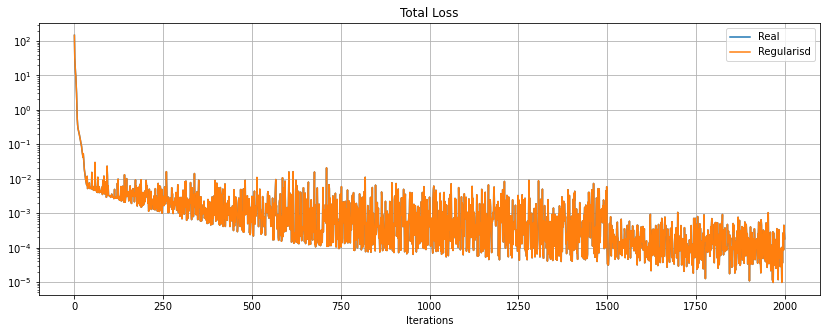

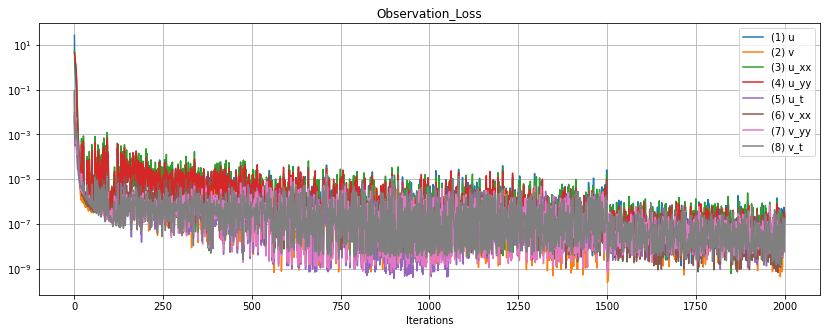

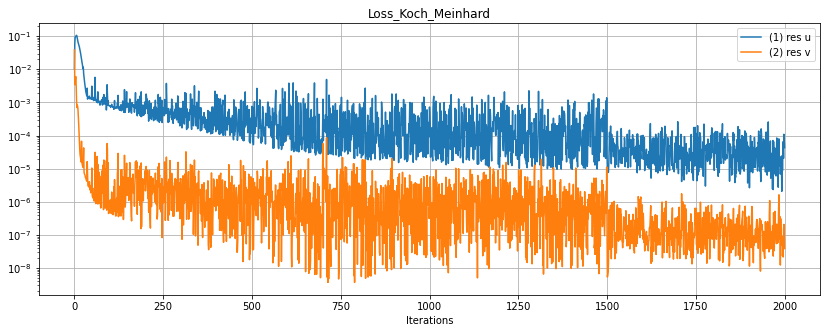

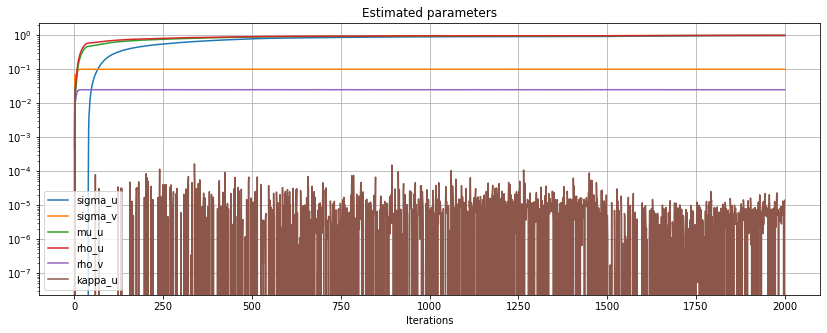

In [147]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3, results_KM4, results_KM5), 
           modelKM, start=0,skip=100, param_names=pde_resKM.parameter_names())

In [140]:
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

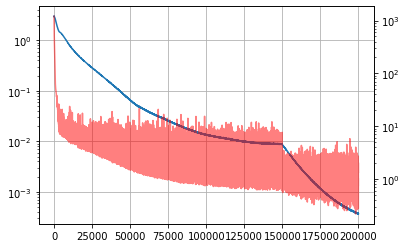

In [148]:
def relative(ax, d, step=1):    
    xs = np.arange(0, d['loss_total'].shape[0])
    ax.plot(xs[::step], 100*np.sqrt(d['loss_total'][::step,]), c='r', alpha=.5)
    
def relative2(ax, d, index, step=1):    
    xs = np.arange(0, d['Observation_Loss_values'][::, index].shape[0])
    ax.plot(xs[::step], 100*np.sqrt(d['Observation_Loss_values'][::step, index]))
    
ax = plt.gca()
ax.plot(norm_params2(merge_dict(results_KM, results_KM2, results_KM3, results_KM4, results_KM5), simulation))
plt.yscale('log')
plt.grid()
ax2 = ax.twinx()
relative(ax2, merge_dict(results_KM, results_KM2, results_KM3, results_KM4, results_KM5), 10)
#relative2(ax2, merge_dict(results_KM, results_KM2), 0, 1000)
#relative2(ax2, merge_dict(results_KM, results_KM2), 1, 1000)
plt.yscale('log')
plt.show()

In [55]:
test_d = obs_X[:,:3].astype(np.float32)

In [56]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[0.13570936, 0.0017187145]
[0.13570938 0.00171871]
[0.36838752 0.04145738]


In [57]:
outputs =  pinnKM.net(test_d)
#u_xx = outputs[:,0]
#u,  u_xx = (outputs[:,0], outputs[:,1])
#u, v, u_xx = (outputs[:,0], outputs[:,1], outputs[:,2])
#u, v, u_xx, v_xx = (outputs[:,0], outputs[:,1], outputs[:,2], outputs[:,3])
u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (outputs[:,0], outputs[:,1], outputs[:,2],
                                         outputs[:,3], outputs[:,4], outputs[:,5],
                                         outputs[:,6], outputs[:,7])

u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [58]:
der_u_outputs.shape

(32, 3)

In [59]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.00023127742918365937
0.0003132720120891548
0.00018946742950642464
0.00018476106148128765
0.00015655277936880592
0.00020182073032053513


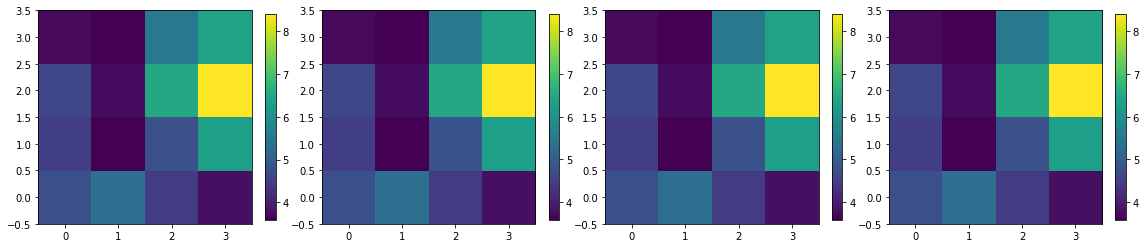

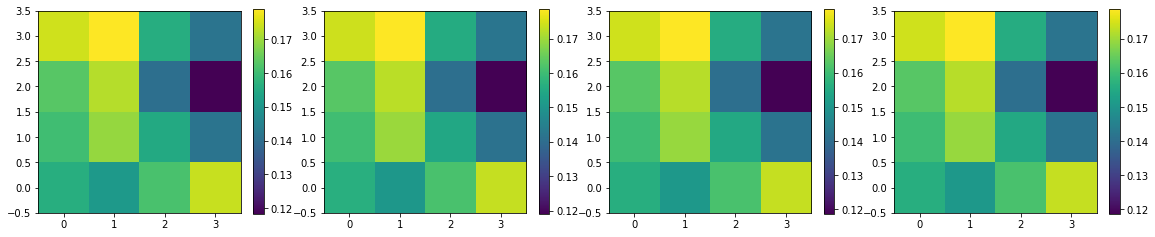

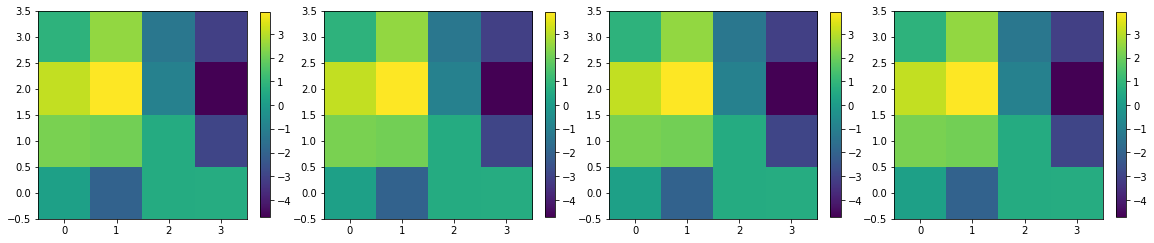

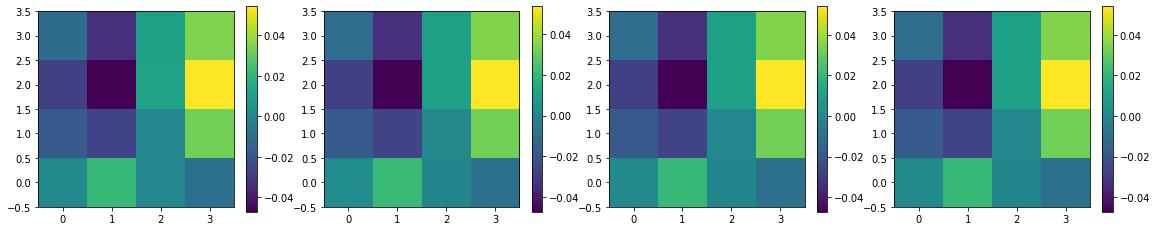

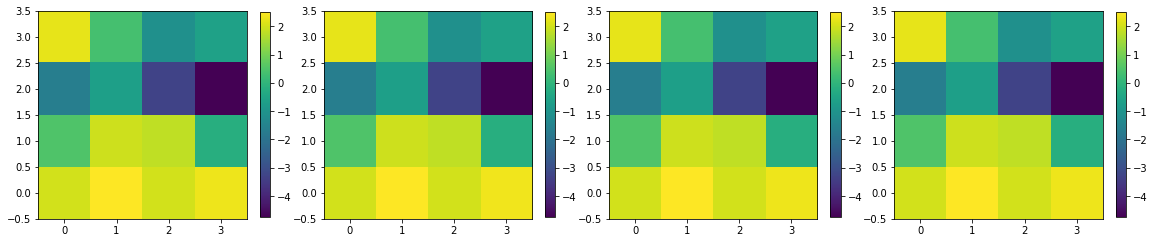

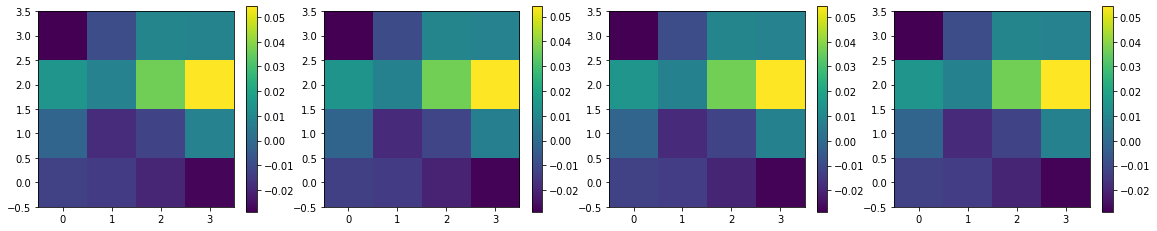

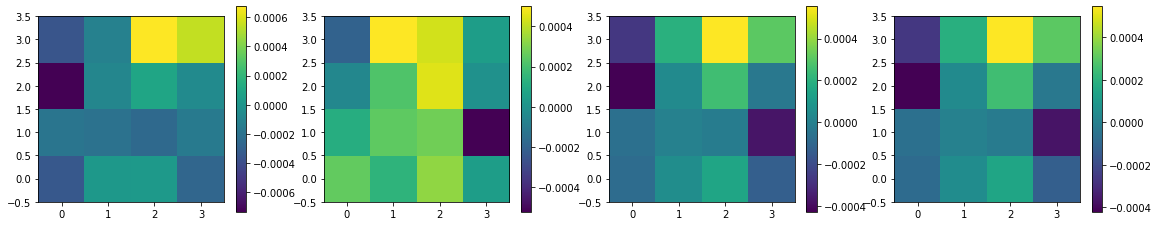

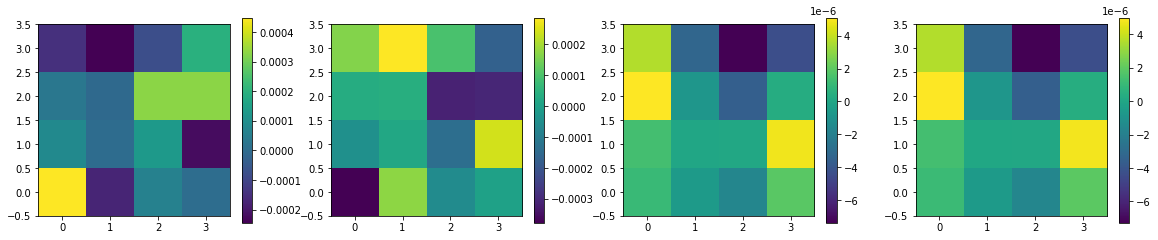

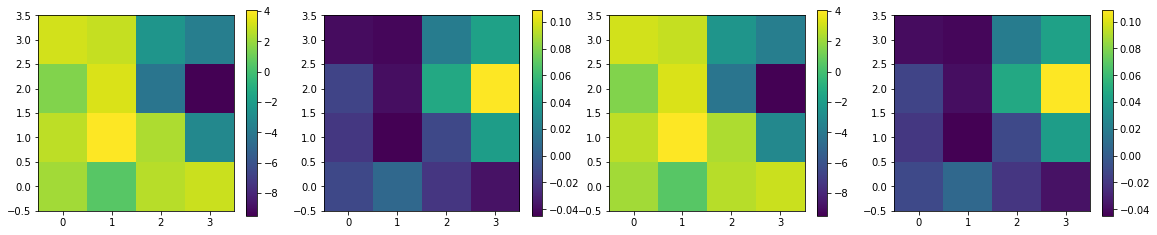

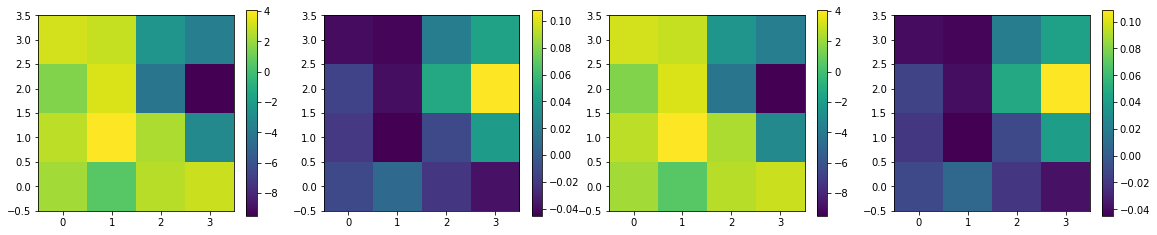

In [60]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [61]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [65]:
params = np.array([simulation.parameters["rho_u"],
                   simulation.parameters["mu_u"],
                   simulation.parameters["sigma_u"],
                   simulation.parameters["rho_v"],
                   simulation.parameters["sigma_v"],])

In [66]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.mu_u.get_value(0).numpy()[0], 
                    pde_resKM.sigma_u.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0],
                    pde_resKM.sigma_v.get_value(0).numpy()[0]])

In [74]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = 0#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = simulation.Ds[0] * (u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = simulation.Ds[1] * (v_xx.numpy() + v_yy.numpy()).flatten()

A_sol = np.vstack((np.c_[f_sol,  -u_sol, [1]*n2,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2,  -f_sol, [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol, vxxyy_sol-v_dt_sol)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [75]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

0.0058291005825991836

In [76]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

0.26213258569872916

In [77]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([0.99936092, 0.9996933 , 0.99835162, 0.02500825, 0.10025737])

In [78]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [71]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

0.04427272354678585

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

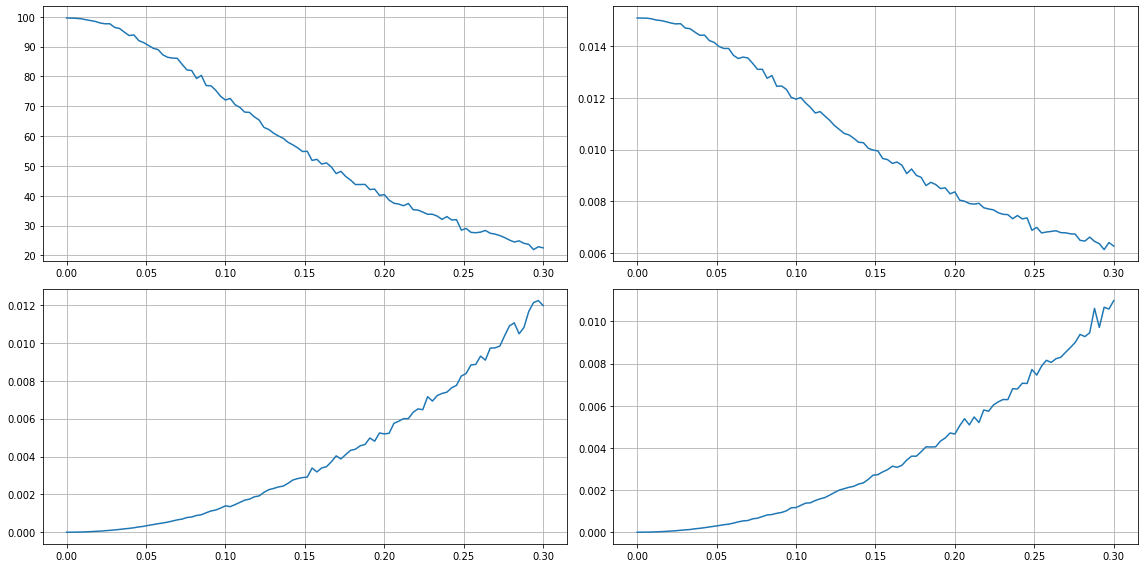

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

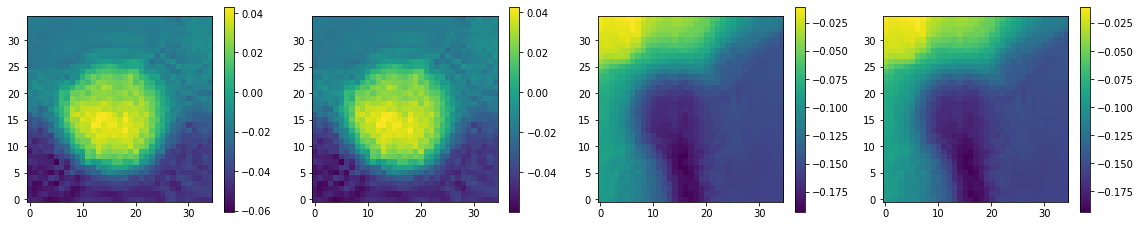

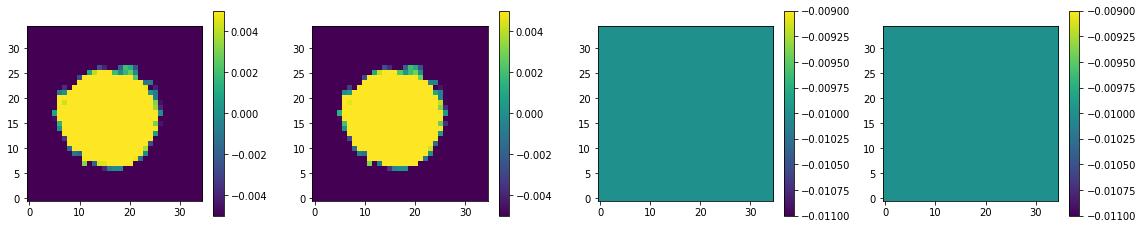

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

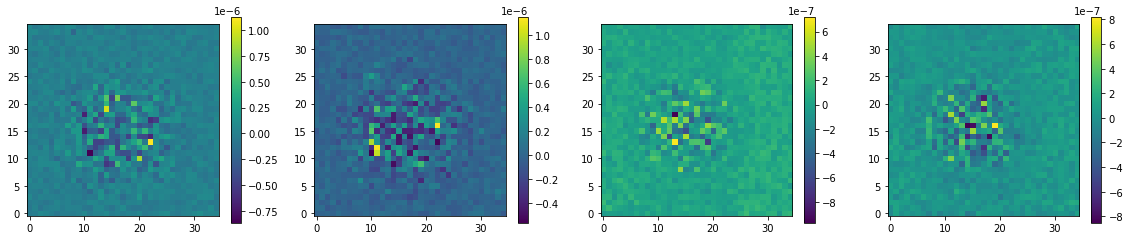

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

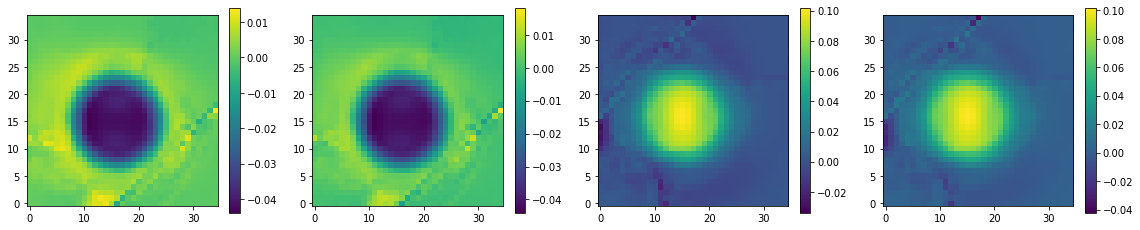

In [161]:
p(res1,res2,res3,res4)

In [62]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [63]:
simulation.Ds

(0.1, 1.0)

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

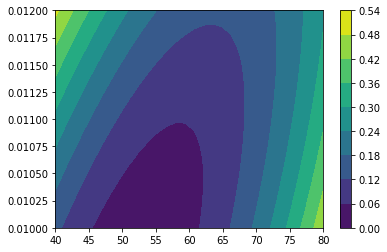

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

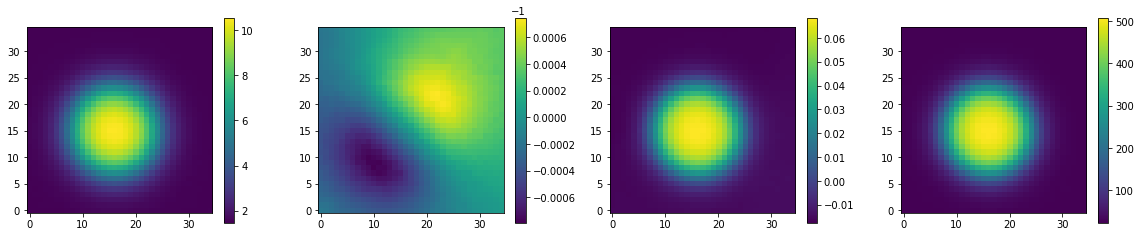

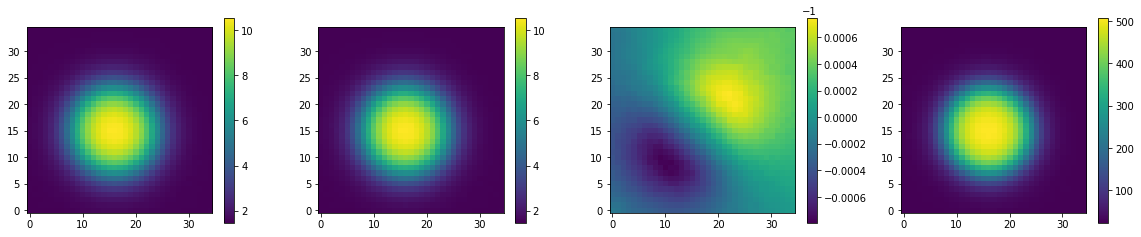

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)